In [1]:
import os
import json

%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns

sns.set_style("darkgrid")

import pandas as pd
import numpy as np

# Loading data and preprocessing

In [2]:
%%time
df = pd.DataFrame.from_csv("/Users/JasonLiu/nyu/Twipsy/labeled.control.dump.csv")

CPU times: user 4.83 s, sys: 354 ms, total: 5.18 s
Wall time: 5.18 s


In [3]:
len(df)

802869

In [4]:
df["time"] = pd.to_datetime(df.created_at)

In [5]:
df.to_csv("./label.control.csv")

In [6]:
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams["figure.dpi"] = 300

### Exploring Time series

1. over a week
2. over a day
3. over the week days

Looking at day of week statistics

#### Preprocessing

here I'm just selecting the relevant data along with creating the appropriate columns

In [7]:
df = df.set_index("time")

In [8]:
p = 0.75

In [9]:
p_firstperson = df.prediction_alcohol_svc * df.prediction_firstperson_svc
of_interest = p_firstperson > p

In [10]:
df["first_person_alcohol"] = 0
df["first_person_alcohol"][of_interest] = 1
df["freq"] = 1

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [11]:
weekdays_index = ["M", "T", "W", "Th", "F", "S", "S"]

# First Level analysis

#### Day of week activity

We look at the probability distribution of a post being posted on a certain day given that a tweet is first person alcohol or not.

We make some obvious obserations such as the fact that 

In [12]:
def plot_groupby(gby, df=df, stat="mean", norm=True, newindex=None, yerr=True, **kwargs):
    temp = df.groupby(gby).agg({"first_person_alcohol":stat, "freq": "sum"})
    
    confidence = df.groupby(gby).agg({"first_person_alcohol":"std", "freq": "sum"})
    confidence.first_person_alcohol /= np.sqrt(confidence.freq)
    confidence.freq = 0
    
    if norm:   
        confidence.first_person_alcohol /= temp.first_person_alcohol.sum()
        confidence.freq /= temp.freq.sum()
        temp.first_person_alcohol /= temp.first_person_alcohol.sum()
        temp.freq /= temp.freq.sum()
         
    if newindex:
        temp.index = newindex
        
    if yerr:
        yerr = 1.96 * confidence
    else:
        yerr = None
    
    temp.plot(figsize=(16, 6), yerr=yerr, **kwargs)
    return temp, confidence
    

# Day of Week Activity Ratios

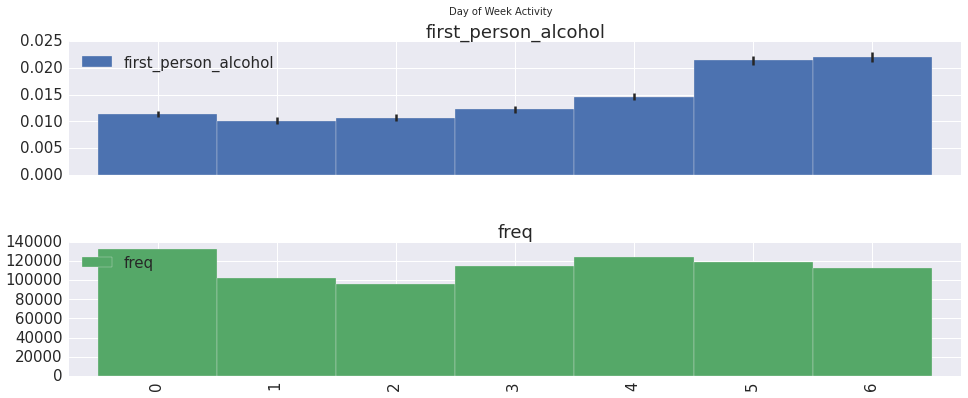

In [13]:
t, c = plot_groupby(
    gby=df.index.dayofweek,
    norm=0, subplots=1, layout=(2,1),
    title="Day of Week Activity", kind="bar", width=1)

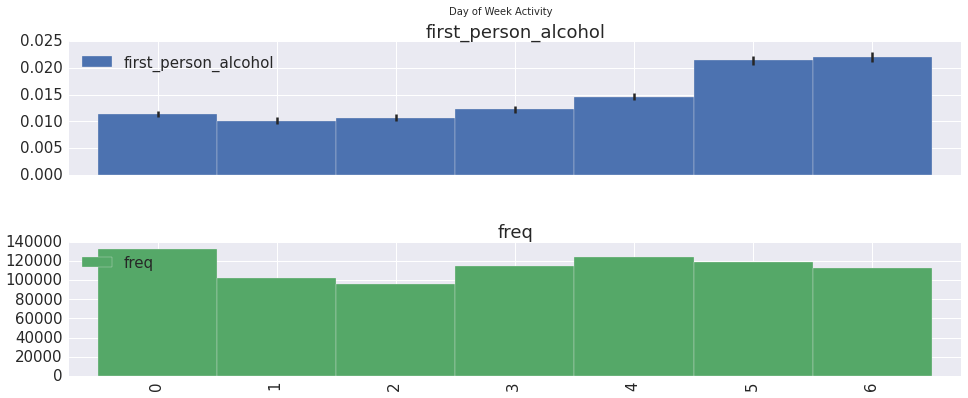

In [14]:
t, c = plot_groupby(
    gby=df.index.dayofweek,
    norm=0, subplots=1, layout=(2,1),
    title="Day of Week Activity", kind="bar", width=1)

# Hour Activity Ratios

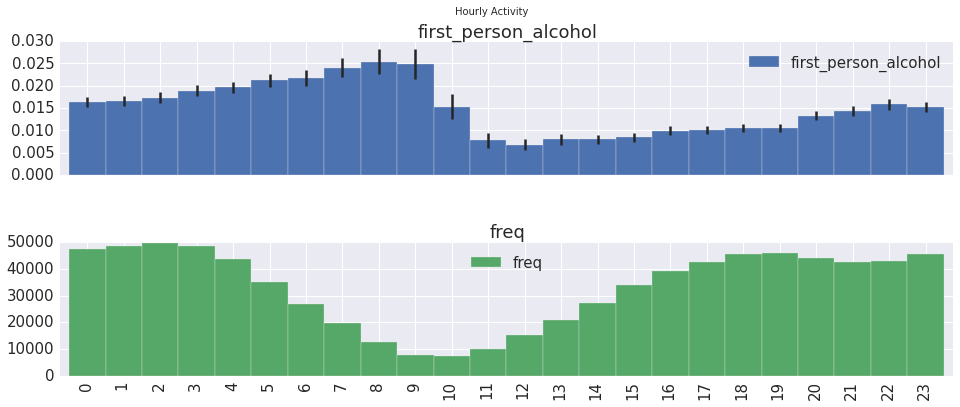

In [15]:
t, c = plot_groupby(
    [df.index.hour], stat="mean", norm=0, subplots=1, layout=(2, 1),
    title="Hourly Activity", kind="bar", width=1)

# Day of week & Hour Activity Ratios

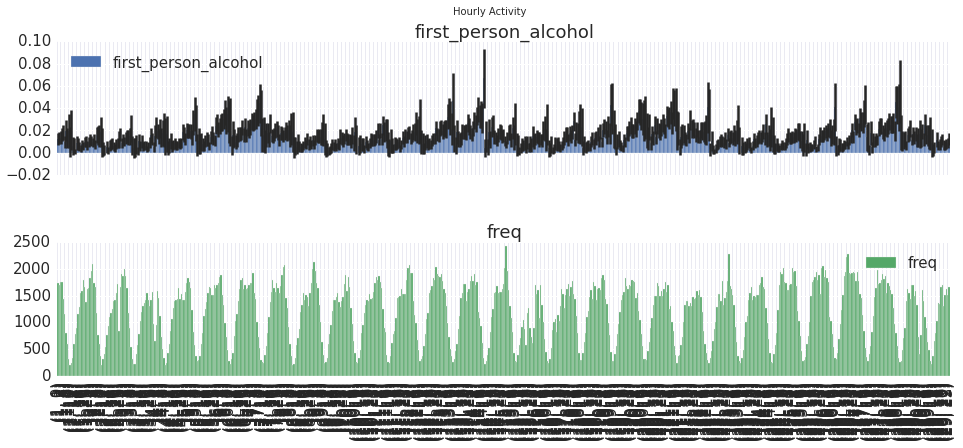

In [16]:
t, c = plot_groupby(
    [df.index.day, df.index.hour], stat="mean", 
    norm=0, subplots=1, layout=(2, 1),
    title="Hourly Activity", kind="bar", width=1)

# Second Level Analysis

In [17]:
col = ["prediction_firstperson_level_0", "prediction_firstperson_level_2", "prediction_firstperson_level_3"]
new_fp_cols = ["casual", "looking", "reflecting"]
for new_name, old_name in zip(new_fp_cols, col):
    df[new_name] = df[old_name] * df.prediction_alcohol_svc * df.prediction_firstperson_svc * df.first_person_alcohol

$ P(class) = P(alch) * P(firstPerson|alch) * P(class|firstPerson, alcoholic)$

In [18]:
def plot_groupby_fp(gby, df=df, stat="mean", norm=True, newindex=None, yerr=True, **kwargs):
    
    temp = df[new_fp_cols].groupby(gby).agg({_:stat for _ in new_fp_cols})
    confidence = df.groupby(gby).agg({_:"std" for _ in new_fp_cols})
    freq = df.groupby(gby).agg({"freq":"sum"})
    
    for c in temp.columns:
        confidence[c] /= np.sqrt(freq.freq)
        if norm: 
            confidence[c] /= temp[c].sum()
            temp[c] /= temp[c].sum()
    
    if newindex:
        temp.index = newindex
        
    if yerr:
        yerr = 1.96 * confidence
    else:
        yerr = None
    
    temp.plot(figsize=(16, 6), yerr=yerr, **kwargs)
    return temp, confidence
    

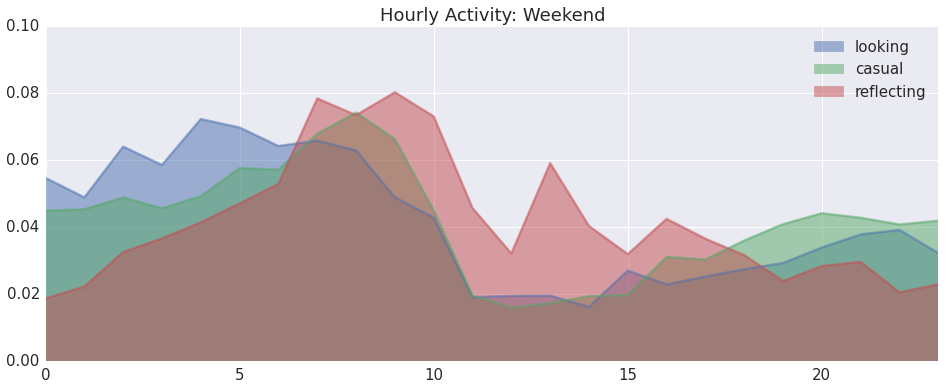

In [19]:
t, c = plot_groupby_fp(
    df.index.hour[df.index.dayofweek >= 5], 
    df=df[df.index.dayofweek >= 5], norm=1, 
    title="Hourly Activity: Weekend",
    kind="area", stacked=0, yerr=None, ylim=[0, 0.1])

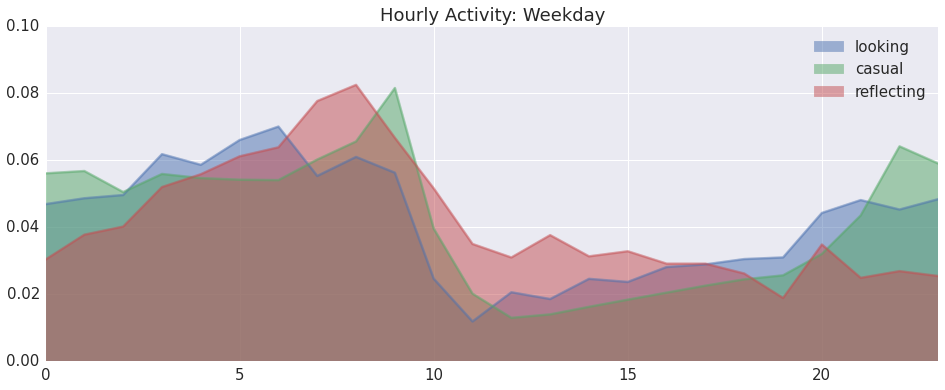

In [20]:
t, c = plot_groupby_fp(
    df.index.hour[df.index.dayofweek < 5], 
    df=df[df.index.dayofweek < 5], norm=1, 
    title="Hourly Activity: Weekday",
    kind="area", stacked=0, yerr=None, ylim=[0, 0.1])

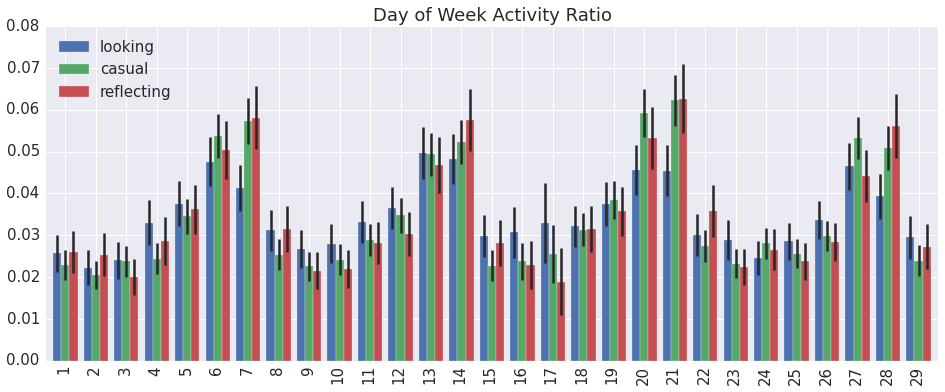

In [21]:
t, c = plot_groupby_fp(
    df.index.day, norm=1, 
    title="Day of Week Activity Ratio",
    kind="bar", width=0.8)

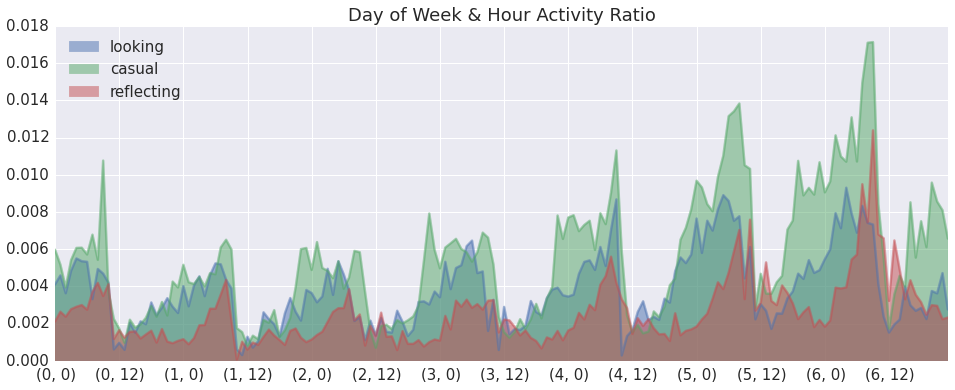

In [29]:
t, c = plot_groupby_fp(
    [df.index.dayofweek, df.index.hour], norm=0, 
    title="Day of Week & Hour Activity Ratio", xticks=[_ for _ in range(24*7) if _%12==0],
    kind="area", stacked=0, yerr=None)

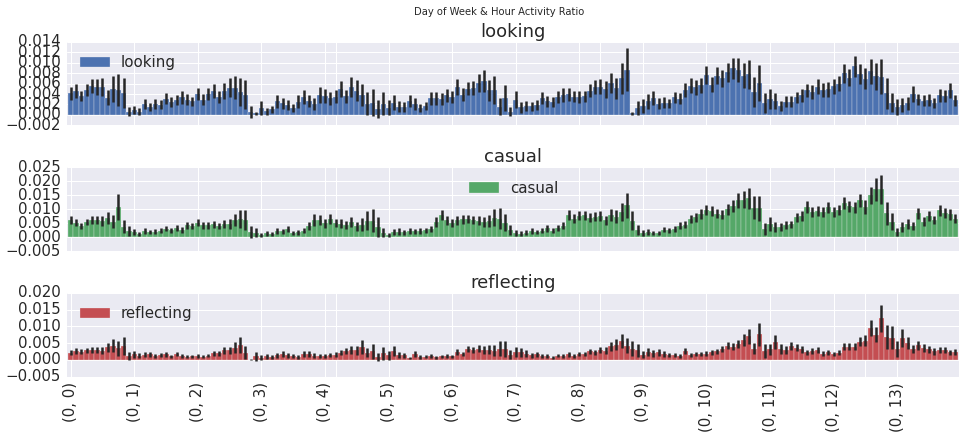

In [30]:
t, c = plot_groupby_fp(
    [df.index.dayofweek, df.index.hour], norm=0, 
    title="Day of Week & Hour Activity Ratio", xticks=[_ for _ in range(24*7) if _%12==0],
    kind="bar", subplots=1, width=1)

# Location Based Analysis

In [24]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

states_inverted = {v:k for (k,v) in states.items()}

In [25]:
def map2name(s):
    if "USA" in s:
        state = s[:-5]
        if state in states_inverted:
            return state
        else:
            return "<Other>"
    try:
        state_code = s[-2:]
        return states[state_code]
    except:
        return "<Other>"
    return "<Other>"

In [31]:
df.head()

,created_at,geo,place_country,place_fullname,source,user_favourites_count,user_followers_count,user_friends_count,user_id,user_screen_name,...,prediction_alcohol_svc,prediction_firstperson_svc,prediction_firstperson_level_0,prediction_firstperson_level_2,prediction_firstperson_level_3,first_person_alcohol,freq,casual,looking,reflecting
time,,,,,,,,,,,,,,,,,,,,,
2015-06-01 00:00:03,Mon Jun 01 00:00:03 +0000 2015,"{'type': 'Point', 'coordinates': [30.272005, -...",United States,"Southside, Jacksonville","<a href=""http://instagram.com"" rel=""nofollow"">...",3010,423,339,429525144,sarahbourgade,...,0.131904,0.523643,0.616766,0.367621,0.015612,0,1,0,0,0
2015-06-01 00:00:06,Mon Jun 01 00:00:06 +0000 2015,"{'type': 'Point', 'coordinates': [40.696258, -...",United States,"Brooklyn, NY","<a href=""http://dlvr.it"" rel=""nofollow"">dlvr.i...",0,1418,289,2864110470,wasnewscom,...,0.500000,0.500000,0.993748,0.001718,0.004534,0,1,0,0,0
2015-06-01 00:00:07,Mon Jun 01 00:00:07 +0000 2015,"{'type': 'Point', 'coordinates': [34.059747, -...",United States,"Los Angeles, CA","<a href=""http://instagram.com"" rel=""nofollow"">...",39,547,1077,88216570,Gillishir,...,0.629574,0.549015,0.957055,0.041217,0.001728,0,1,0,0,0
2015-06-01 00:00:09,Mon Jun 01 00:00:09 +0000 2015,NaN,United States,"Fontana, CA","<a href=""http://twitter.com/download/android"" ...",7011,1346,842,226336956,danelleee__,...,0.114825,0.665164,0.052188,0.101156,0.846657,0,1,0,0,0
2015-06-01 00:00:09,Mon Jun 01 00:00:09 +0000 2015,NaN,United States,"West Hollywood, CA","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",345,2635,1293,484324340,Barihunks,...,0.119263,0.431844,0.564079,0.430679,0.005242,0,1,0,0,0


In [32]:
df["location"] = df.place_fullname.apply(map2name)

TypeError: argument of type 'float' is not iterable

In [ ]:
df.head()

In [ ]:
df.groupby("location").agg(
    {"first_person_alcohol": "mean"}
).sort("first_person_alcohol")

# User Level Signals

In [ ]:
user2scores = df.groupby("user_screen_name").agg(
    {
        "casual":"mean",
        "looking":"mean",
        "reflecting":"mean",
        "first_person_alcohol":["mean", "count"]
    }
)

In [ ]:
relevant_users = user2scores[
    (user2scores.first_person_alcohol["mean"] > 0) 
    & (user2scores.first_person_alcohol["count"] > 100)
    & ((user2scores.first_person_alcohol["count"] < 400))
].index

In [ ]:
from collections import Counter

In [ ]:
def to_transitions(col):
    seq = col.tolist()
    c = Counter()
    bigrams = zip(seq, seq[1:])
    c.update(bigrams)
    k = {k:v/len(seq) for k,v in dict(c).items()}
    return (k,)

# Mens and Womens

# Correlation and Time Lag